## yfactor_sisv_sweep_necstdb.py 用可視化ツールの template です。
- 概要：
  - 全 cell を実行すると、20 IF の hot / cold の SIS vsweep 時の y-factor が表示されます
- 特筆事項：
  - 20 IF 分のデータが存在しなくても、存在する IF データのみで plot 可能です
-  <font color="red">notebook 上で plot を行いたい場合：　</font>
  - 「モジュールを import します。」 の cell で%matplotlib inline のコメントアウトを外してください

### モジュールを import します。

In [27]:
import os
import sys
import time
import numpy as np
import pandas
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import necstdb

### database を読み込みます。

In [3]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

date = '20190831_031800'

data_path_hot = '/home/amigos/data/rx/{mode}/hot/{date}.necstdb/'.format(**locals())
data_path_cold = '/home/amigos/data/rx/{mode}/cold/{date}.necstdb/'.format(**locals())

# data_path = [
#     '/mnt/media/usbdisk/data/rx/{mode}/hot/{date}'.format(**locals()),
#     '/mnt/media/usbdisk/data/rx/{mode}/cold/{date}'.format(**locals())
# ]

db_hot = necstdb.opendb(data_path_hot)
db_cold = necstdb.opendb(data_path_cold)

In [4]:
IF_list = [
    '2l_usb', '2l_lsb', '2r_usb', '2r_lsb',
    '3l_usb', '3l_lsb', '3r_usb', '3r_lsb',
    '4l_usb', '4l_lsb', '4r_usb', '4r_lsb',
    '5l_usb', '5l_lsb', '5r_usb', '5r_lsb',
    '1lu', '1ll', '1ru', '1rl'
]
beam_list = [
    '2l', '2r', '3l', '3r',
    '4l', '4r', '5l', '5r', 
    '1lu', '1ll', '1ru', '1rl'
]
beam_for_IF_list = [
    '2l', '2r', '2l', '2r',
    '3l', '3r', '3l', '3r',
    '4l', '4r', '4l', '4r',
    '5l', '5r', '5l', '5r' ,
    '1lu', '1ll', '1ru', '1rl'
]

In [5]:
vol_topic_list = ['sis_vol_{}'.format(vol) for vol in beam_list]
cur_topic_list = ['sis_cur_{}'.format(cur) for cur in beam_list]
IF_topic_list = ['if_{}'.format(IF) for IF in IF_list]

In [6]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

date = '20190831_031800'

data_path_hot = '/home/amigos/data/rx/{mode}/hot/{date}.necstdb/'.format(**locals())
data_path_cold = '/home/amigos/data/rx/{mode}/cold/{date}.necstdb/'.format(**locals())

# data_path = [
#     '/mnt/media/usbdisk/data/rx/{mode}/hot/{date}'.format(**locals()),
#     '/mnt/media/usbdisk/data/rx/{mode}/cold/{date}'.format(**locals())
# ]

db_hot = necstdb.opendb(data_path_hot)
db_cold = necstdb.opendb(data_path_cold)

In [7]:
raw_vol_df_hot = [db_hot.open_table(vol_topic).read(astype='pandas') for vol_topic in vol_topic_list]
raw_cur_df_hot = [db_hot.open_table(cur_topic).read(astype='pandas') for cur_topic in cur_topic_list]
raw_IF_df_hot = [db_hot.open_table(IF_topic).read(astype='pandas') for IF_topic in IF_topic_list]
raw_vol_df_cold = [db_cold.open_table(vol_topic).read(astype='pandas') for vol_topic in vol_topic_list]
raw_cur_df_cold = [db_cold.open_table(cur_topic).read(astype='pandas') for cur_topic in cur_topic_list]
raw_IF_df_cold = [db_cold.open_table(IF_topic).read(astype='pandas') for IF_topic in IF_topic_list]

for ts_vol_hot, ts_cur_hot, ts_IF_hot, ts_vol_cold, ts_cur_cold, ts_IF_cold \
in zip(raw_vol_df_hot, raw_cur_df_hot, raw_IF_df_hot, raw_vol_df_cold, raw_cur_df_cold, raw_IF_df_cold):
        ts_vol_hot['timestamp'] = pd.to_datetime(ts_vol_hot['timestamp'], unit='s')
        ts_cur_hot['timestamp'] = pd.to_datetime(ts_cur_hot['timestamp'], unit='s')
        ts_vol_cold['timestamp'] = pd.to_datetime(ts_vol_cold['timestamp'], unit='s')
        ts_cur_cold['timestamp'] = pd.to_datetime(ts_cur_cold['timestamp'], unit='s')
        
for ts_IF_hot, ts_IF_cold in zip(raw_IF_df_hot, raw_IF_df_cold):        
        ts_IF_hot['timestamp'] = pd.to_datetime(ts_IF_hot['timestamp'], unit='s')
        ts_IF_cold['timestamp'] = pd.to_datetime(ts_IF_cold['timestamp'], unit='s')
        
vol_df_hot, vol_df_cold, cur_df_hot, cur_df_cold = {}, {}, {}, {}
IF_df_hot, IF_df_cold = {}, {}
for idx, beam in enumerate(beam_list):
    vol_df_hot[beam] = raw_vol_df_hot[idx].set_index('timestamp').sort_index()
    vol_df_cold[beam] = raw_vol_df_cold[idx].set_index('timestamp').sort_index()
    cur_df_hot[beam] = raw_cur_df_hot[idx].set_index('timestamp').sort_index()    
    cur_df_cold[beam] = raw_cur_df_cold[idx].set_index('timestamp').sort_index()        
for idx, IF in enumerate(IF_list):    
    IF_df_hot[IF] = raw_IF_df_hot[idx].set_index('timestamp').sort_index()
    IF_df_cold[IF] = raw_IF_df_cold[idx].set_index('timestamp').sort_index()

In [11]:
dataset = {}
resample_time = '0.04S'
for IF in IF_list:
    if IF in IF_list[:16]:
        if '_usb' in IF: beam = IF.replace('_usb', '')
        elif '_lsb' in IF: beam = IF.replace('_lsb', '')
    elif IF in IF_list[16:]: beam = IF
    dataset[IF]  = pd.concat(
        [
            pd.concat(
                [
                    vol_df_hot['{}'.format(beam)].rename(columns={'data': 'sis_vol_{}'.format(IF)}) \
                    .astype(float).resample(resample_time).mean().round({'sis_vol_{}'.format(IF): 2}),
                    cur_df_hot['{}'.format(beam)].rename(columns={'data': 'sis_cur_{}_hot'.format(IF)}) \
                    .astype(float).resample(resample_time).mean(),
                    IF_df_hot['{}'.format(IF)].rename(columns={'data': 'if_{}_hot'.format(IF)}) \
                    .astype(float).resample(resample_time).mean(),    
                ],
                axis=1
                ).set_index('sis_vol_{}'.format(IF)).groupby(level=0).mean(),

            pd.concat(
                [
                    vol_df_cold['{}'.format(beam)].rename(columns={'data': 'sis_vol_{}'.format(IF)}) \
                    .astype(float).resample(resample_time).mean().round({'sis_vol_{}'.format(IF): 2}),
                    cur_df_cold['{}'.format(beam)].rename(columns={'data': 'sis_cur_{}_cold'.format(IF)}) \
                    .astype(float).resample(resample_time).mean(),
                    IF_df_cold['{}'.format(IF)].rename(columns={'data': 'if_{}_cold'.format(IF)}) \
                    .astype(float).resample(resample_time).mean(),
                ],
                axis=1
                ).set_index('sis_vol_{}'.format(IF)).groupby(level=0).mean(),
            ],
            axis=1
    )


info : Saved image. ( hot_cold.png )


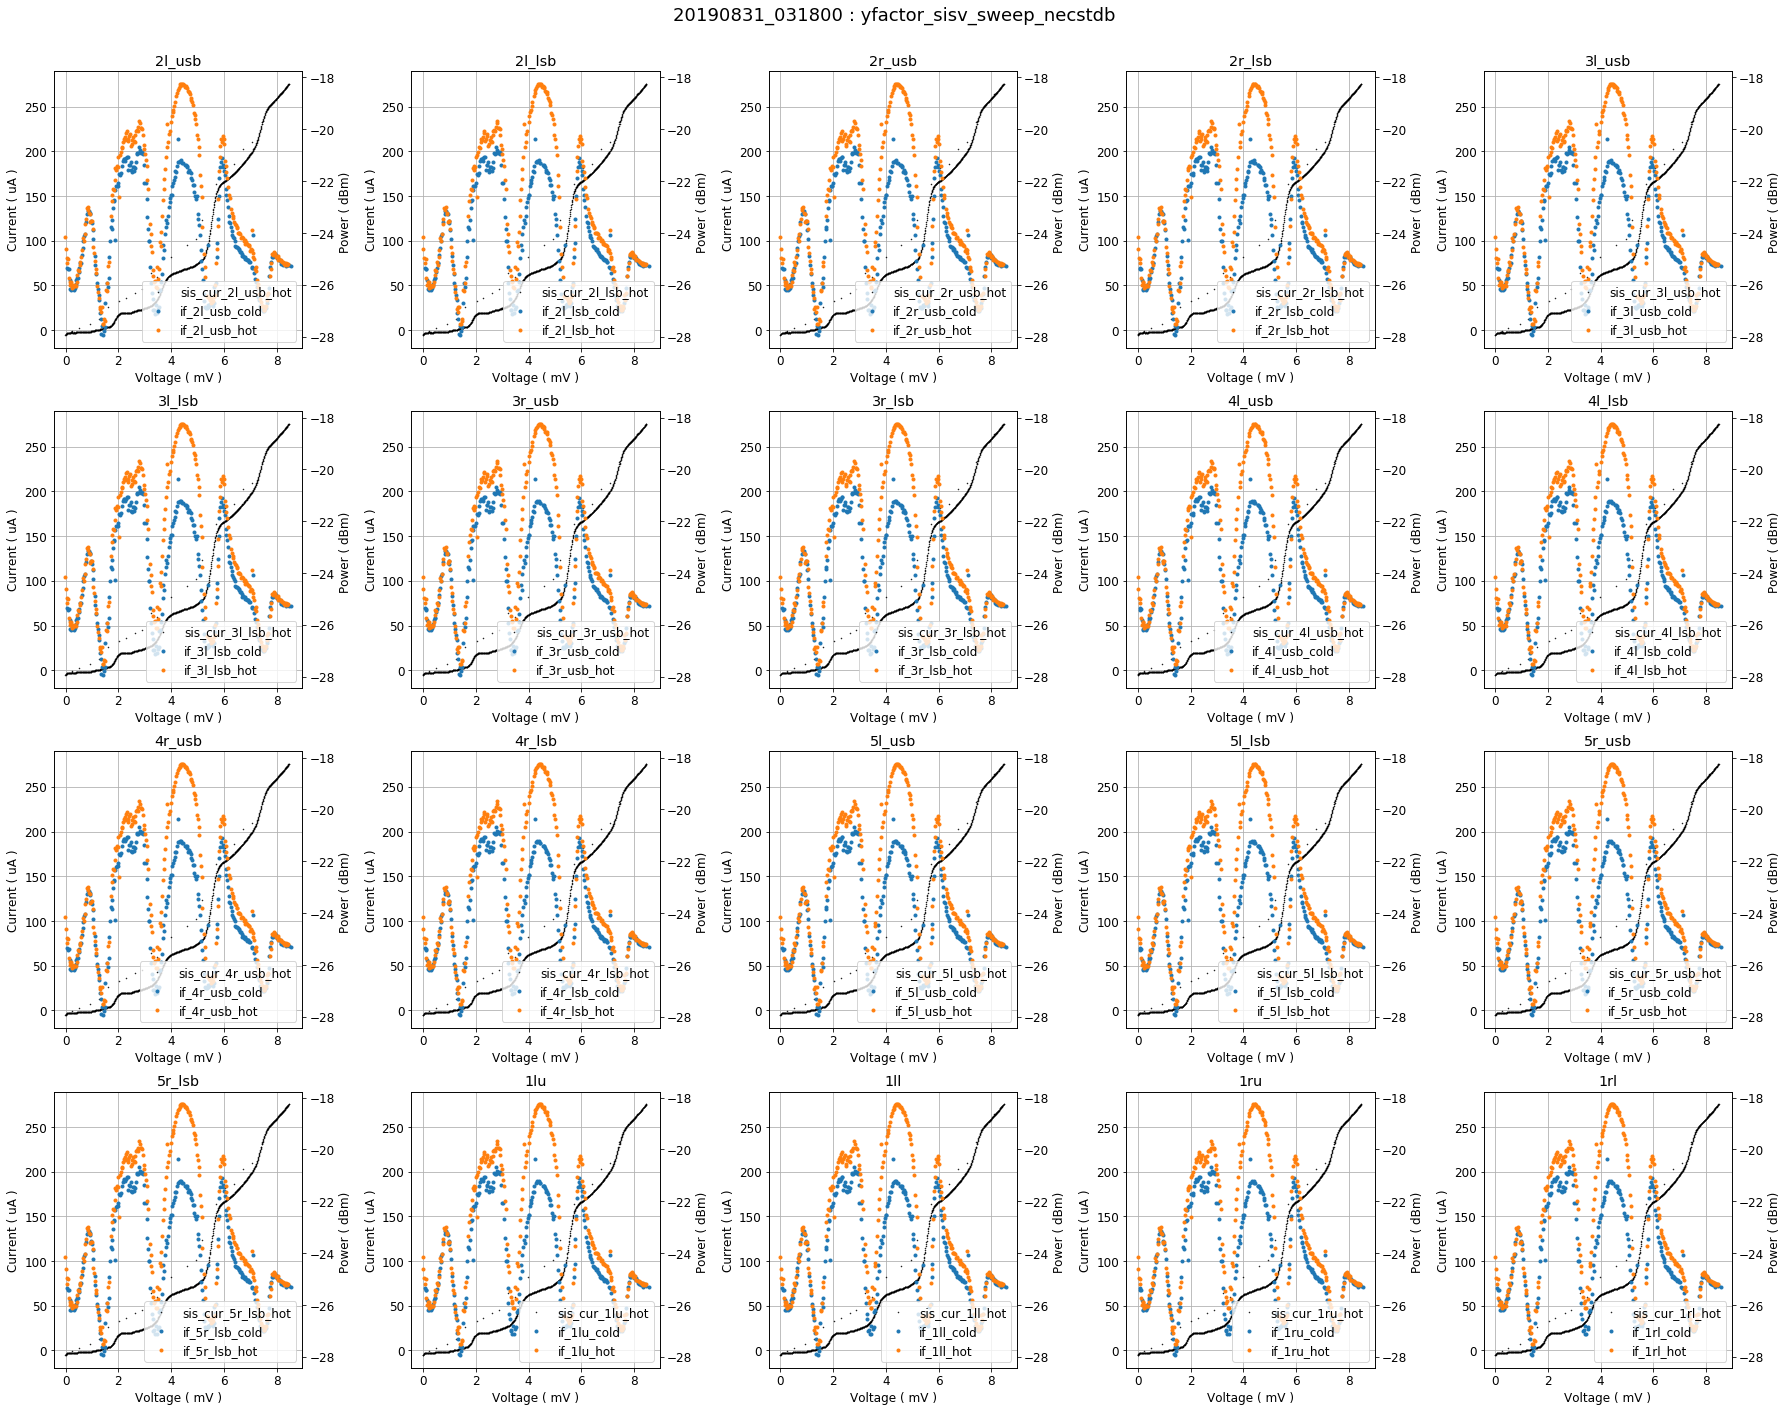

In [35]:
ncol = 5
nrow = 4
nax = ncol * nrow

figsize = (ncol * 5, nrow * 5)

fig = matplotlib.pyplot.figure(figsize=figsize)
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax)]

for _ax, key, data in zip(ax, dataset.keys(), dataset.values()):
    _ax_ = _ax.twinx()
    _ax.plot((data['sis_cur_{}_hot'.format(key)] + data['sis_cur_{}_hot'.format(key)]) / 2., '.', c='k', markersize=1)
    _ax.set_xlabel('Voltage ( mV )')
    _ax.set_ylabel('Current ( uA )')
    _ax.set_title(key)
    _ax.grid()
    
    _ax_.plot(data['if_{}_cold'.format(key)], '.')
    _ax_.plot(data['if_{}_hot'.format(key)], '.')
    _ax_.set_ylabel('Power ( dBm) ')

    h1, l1 = _ax.get_legend_handles_labels()
    h2, l2 = _ax_.get_legend_handles_labels()
    _ax_.legend(h1 + h2, l1 + l2, loc = 'lower right')
#     _ax.legend()    
    
plt.suptitle('{date} : {mode}'.format(**locals()), fontsize=18)
plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.05)
plt.tight_layout()
plt.subplots_adjust(top=0.935)

plt.savefig('./hot_cold.png')
print('info : Saved image. ( hot_cold.png )')